In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
# Import Modules
from keras.models import Sequential,Model
from keras.layers import Input, LSTM, Bidirectional,Dense,Conv1D, Conv2D, MaxPooling1D,MaxPool2D, Flatten, Dropout,TimeDistributed,Multiply
from keras import optimizers

from keras.layers.core import *
from keras.models import *
from utils import *

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 1. Preprocess

## Load data

In [3]:
BYD = pd.read_excel("BYD.xls")

In [4]:
row_dataset = BYD.set_index('Dates') 
dataset = row_dataset.dropna()
dataset.iloc[:,1]

Dates
2012-01-03     3915141.0
2012-01-04     3884939.0
2012-01-05     1037158.0
2012-01-06     2347350.0
2012-01-09     4187700.0
                 ...    
2022-06-24     8076367.0
2022-06-27     8232609.0
2022-06-28    11753720.0
2022-06-29    12721490.0
2022-06-30     7749814.0
Name:  volume, Length: 2574, dtype: float64

In [5]:
def on_balance_volume_creation(stock_df):
    
    # Adding of on balance volume to dataframe
    
    new_df = pd.DataFrame({})

    new_df = stock_df[['share_pricing']].copy()


    new_balance_volume = [0]
    tally = 0

    #Adding the volume if the 
    for i in range(1, len(new_df)):
        if (stock_df['share_pricing'][i] > stock_df['share_pricing'][i - 1]):
            tally += stock_df.iloc[:,1][i]
        elif (stock_df['share_pricing'][i] < stock_df['share_pricing'][i - 1]):
            tally -= stock_df.iloc[:,1][i]
        new_balance_volume.append(tally)

    new_df['On_Balance_Volume'] = new_balance_volume
    minimum = min(new_df['On_Balance_Volume'])

    new_df['On_Balance_Volume'] = new_df['On_Balance_Volume'] - minimum
    new_df['On_Balance_Volume'] = (new_df['On_Balance_Volume']+1).transform(np.log)

    return new_df


new_df = on_balance_volume_creation(dataset)
new_df

,share_pricing,On_Balance_Volume
Dates,,
2012-01-03,18.12,15.799191
2012-01-04,17.84,15.034719
2012-01-05,17.80,14.668798
2012-01-06,17.06,0.000000
2012-01-09,18.24,15.247662
...,...,...
2022-06-24,310.20,20.717655
2022-06-27,318.00,20.725900
2022-06-28,331.40,20.737555


## Train-test spllit

In [6]:
train = new_df[:2000]
test = new_df[2000:]
len(train)

2000

In [7]:
def add_technical_indicators(data,days=21,smoothing=2):
    # Calculated EMA
    ema = [sum(data['share_pricing'][:days]) / days]
    for price in data['share_pricing'][days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    zeros = np.zeros(20)
    ema1 = np.append(zeros,ema)
    data['EMA'] = ema1.copy()
    bb = np.zeros(len(data))
    data['bb_upper'] = bb.copy()
    data['bb_lower'] = bb.copy()
   
    #Filling of missing data as Bollinger Bands is based on a 21 day EMA
    std =  data['share_pricing'].rolling(21).std()
    
    for i in range(20,len(data)-days):
        higher = data['EMA'][i] + 2 * std[i]
        lower = data['EMA'][i] - 2 * std[i]
        data['bb_upper'][i] = higher
        data['bb_lower'][i] = lower

    return data

train = add_technical_indicators(train)
test = add_technical_indicators(test)



/var/folders/dg/2kry1x8x3n5fr3_r_zjpf1f80000gn/T/ipykernel_12668/812864544.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EMA'] = ema1.copy()
/var/folders/dg/2kry1x8x3n5fr3_r_zjpf1f80000gn/T/ipykernel_12668/812864544.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bb_upper'] = bb.copy()
/var/folders/dg/2kry1x8x3n5fr3_r_zjpf1f80000gn/T/ipykernel_12668/812864544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

## Clean data

In [9]:
df_train = train[(train[['EMA','bb_upper','bb_lower']] != 0).all(axis=1)]
df_test = test[(test[['EMA','bb_upper','bb_lower']] != 0).all(axis=1)]
df_train

,share_pricing,On_Balance_Volume,EMA,bb_upper,bb_lower
Dates,,,,,
2012-02-03,24.65,18.078600,21.351429,26.514661,16.188196
2012-02-06,24.90,18.124567,21.674026,26.836508,16.511544
2012-02-07,25.90,18.216312,22.058205,27.221877,16.894534
2012-02-08,28.35,18.391067,22.630187,28.097802,17.162571
2012-02-09,27.25,18.314107,23.050170,28.270628,17.829712
...,...,...,...,...,...
2020-01-23,46.35,20.059555,43.014562,51.172112,34.857012
2020-01-24,46.20,20.052676,43.304147,51.395448,35.212847
2020-01-29,43.20,20.036707,43.294679,51.065387,35.523971


## Normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(df_train)
scaler2.fit(df_test)
train_scaled = scaler1.transform(df_train)
test_scaled = scaler2.transform(df_test)
np.allclose(df_train, scaler1.inverse_transform(train_scaled))
np.allclose(df_test, scaler2.inverse_transform(test_scaled))

True

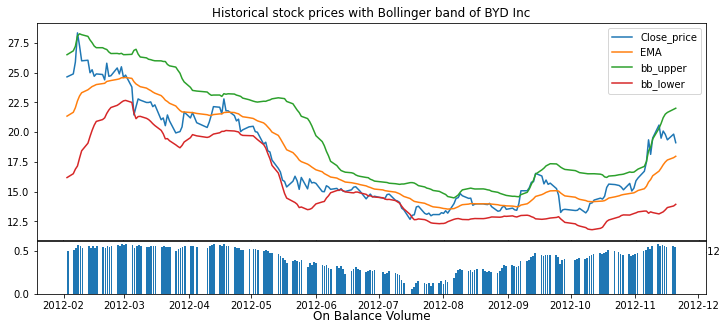

In [11]:
top_plt = plt.subplot2grid((40,70), (0, 0), rowspan=20, colspan=70)
top_plt.plot(df_train[["share_pricing",'EMA','bb_upper','bb_lower']][:200])
plt.legend(["Close_price",'EMA','bb_upper','bb_lower'])
plt.title('Historical stock prices with Bollinger band of BYD Inc')
bottom_plt = plt.subplot2grid((40,70), (20,0), rowspan=5, colspan=70)
bottom_plt.bar(df_train.index[:200], train_scaled[:,1][:200])
plt.title('On Balance Volume', y=-0.60)
plt.gcf().set_size_inches(12,8)

### Feature, Target split

In [12]:
def construct_X(data, ntimes, step):
    X_train_concat = []
    for i in range(len(data) - (ntimes)*step):
        X_train_concat.append(data[i:i+ntimes*step])
    return np.array(X_train_concat)

def construct_Y(data, ntimes, step):
    y_train_concat = []
    for i in range(len(data) - (ntimes)*step):
        y_train_concat.append(data['share_pricing'][i+ntimes])
    y = np.array(y_train_concat)
    y = np.reshape(y,[y.shape[0],1])
    return np.array(y)

In [13]:
df_train

,share_pricing,On_Balance_Volume,EMA,bb_upper,bb_lower
Dates,,,,,
2012-02-03,24.65,18.078600,21.351429,26.514661,16.188196
2012-02-06,24.90,18.124567,21.674026,26.836508,16.511544
2012-02-07,25.90,18.216312,22.058205,27.221877,16.894534
2012-02-08,28.35,18.391067,22.630187,28.097802,17.162571
2012-02-09,27.25,18.314107,23.050170,28.270628,17.829712
...,...,...,...,...,...
2020-01-23,46.35,20.059555,43.014562,51.172112,34.857012
2020-01-24,46.20,20.052676,43.304147,51.395448,35.212847
2020-01-29,43.20,20.036707,43.294679,51.065387,35.523971


In [16]:
x_train = construct_X(train_scaled,21,1)
y_train_noscaled = construct_Y(df_train,21,1)
x_test = construct_X(test_scaled,21,1)
y_test_noscaled = construct_Y(df_test,21,1)

scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler3.fit(y_train_noscaled)
y_train = scaler3.transform(y_train_noscaled)

scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler4.fit(y_test_noscaled)
y_test = scaler4.transform(y_test_noscaled)

np.allclose(y_train_noscaled, scaler3.inverse_transform(y_train))
np.allclose(y_test_noscaled, scaler4.inverse_transform(y_test))

True

In [17]:
print(x_train.shape,y_train.shape)

(1938, 21, 5) (1938, 1)


# 2. Comparing NN models on index prediction 

* lstm+attention

In [412]:
def attention_3d_block(inputs, single_attention_vector=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = 21
    input_dim = 3
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x:mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model(INPUT_DIMS = 5,TIME_STEPS = 21,lstm_units = 64):
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [413]:
atten = attention_model()
adam = optimizers.Adam(learning_rate = 0.005)
# Compile 
atten.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
history = atten.fit(x_train, y_train,batch_size=16, epochs=20,validation_split=0.2)
atten.summary()

Training model...
Epoch 1/20
97/97 [==============================] - 4s 15ms/step - loss: 0.0125 - val_loss: 0.0019
Epoch 2/20
97/97 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 3/20
97/97 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/20
97/97 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 6.0802e-04
Epoch 5/20
97/97 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 7.0048e-04
Epoch 6/20
97/97 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 9.0459e-04
Epoch 7/20
97/97 [==============================] - 1s 8ms/step - loss: 9.4241e-04 - val_loss: 5.2472e-04
Epoch 8/20
97/97 [==============================] - 1s 9ms/step - loss: 8.0650e-04 - val_loss: 8.1812e-04
Epoch 9/20
97/97 [==============================] - 1s 9ms/step - loss: 8.6375e-04 - val_loss: 6.4530e-04
Epoch 10/20
97/97 [==============================] - 1s 9ms/ste

In [414]:
y_pred_atten_train = atten.predict(x_train)
y_pred_atten_test = atten.predict(x_test)
y_pred_atten_train1 = scaler3.inverse_transform(y_pred_atten_train)
y_pred_atten_test1 = scaler4.inverse_transform(y_pred_atten_test)

rmse_atten = sqrt(mean_squared_error(y_train_noscaled, y_pred_atten_train1))
rmse_atten1 = sqrt(mean_squared_error(y_test_noscaled, y_pred_atten_test1))
r2_atten = r2_score(y_train_noscaled,y_pred_atten_train1)
r2_atten1 = r2_score(y_test_noscaled,y_pred_atten_test1) 
print(rmse_atten,rmse_atten1,r2_atten,r2_atten1)

16/16 [==============================] - 0s 4ms/step
1.6304170249475538 9.295043417340015 0.985336187499413 0.9846242330090018


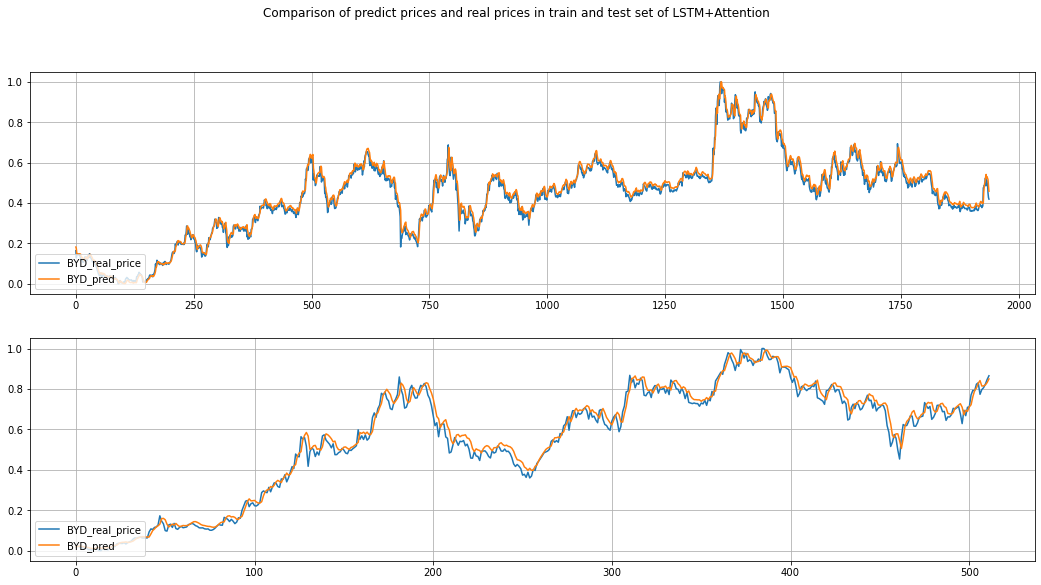

In [415]:
fig, ax = plt.subplots(2, figsize=[18,9])
fig.suptitle('Comparison of predict prices and real prices in train and test set of LSTM+Attention')
ax[0].plot(y_train[:,0])
ax[0].plot(y_pred_atten_train[:,0])
ax[0].grid()
ax[0].legend(['BYD_real_price','BYD_pred'],loc='lower left')
ax[1].plot(y_test[:,0])
ax[1].plot(y_pred_atten_test[:,0])
ax[1].grid()
ax[1].legend(['BYD_real_price','BYD_pred'],loc='lower left')

In [19]:
def construct_X(data, lookback, step):
    X_train_concat = []
    a = (lookback+step)
    for i in range(len(data) - a):
        X_train_concat.append(data[i:(i+lookback),:])
    return np.array(X_train_concat)

def construct_Y(data, lookback, step):
    Y_train_concat = []
    for i in range(lookback,(len(data) - step)):
        Y_train_concat.append(data[i:(i+step),0])
    y = np.array(Y_train_concat)
    y = np.reshape(y,(y.shape[0],5,1))
    return np.array(y)


In [20]:
def con_X(data, lookback, step):
    conx = []
    index = np.arange(0,data.shape[0]-105,step)
    for i in index:
        conx.append(data[i:(i+lookback)])
    return np.array(conx)

def con_Y(data, lookback, step):
    cony = []
    index = np.arange(lookback,data.shape[0]-step,step)
    for i in index:
        cony.append(data[i:(i+step),0])
    y = np.array(cony)
    y = np.reshape(y,(y.shape[0],5,1))
    return np.array(y)

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
train_data =df_train.values
train_data = train_data.reshape(train_data.shape[0],-1)
train_scaled = scaler1.fit_transform(train_data)

test_data =df_test.values
test_data = test_data.reshape(test_data.shape[0],-1)
test_scaled = scaler2.fit_transform(test_data)

np.allclose(train_data, scaler1.inverse_transform(train_scaled))
np.allclose(test_data, scaler2.inverse_transform(test_scaled))
x_train = construct_X(train_scaled,100,5)
y_train = construct_Y(train_scaled,100,5)
x_test = construct_X(test_scaled,100,5)
y_test = construct_Y(test_scaled,100,5)
conx = con_X(train_scaled,100,5)
cony = con_Y(train_scaled,100,5)
conx_test = con_X(test_scaled,100,5)
cony_test = con_Y(test_scaled,100,5)

##x_train_dataset = x_train.reshape(x_train.shape[0], 21, 1, 1).astype('float32')
#X_train_dataset = tf.data.Dataset.from_tensor_slices((x_train_dataset))
#X_train_dataset = X_train_dataset.batch(64)
#y_train_dataset = y_train.reshape(y_train.shape[0], 21, 1, 1).astype('float32')
#train_dataset_all = tf.data.Dataset.from_tensor_slices((X_train_dataset,y_train_dataset))
#train_dataset_all = train_dataset_all.batch(64)
#train_dataset_all

In [22]:
print(x_train.shape,y_train.shape)
print(conx.shape,cony_test.shape)

(1854, 100, 5) (1854, 5, 1)
(371, 100, 5) (86, 5, 1)


In [25]:
#expand_dims is used to prepare the dataset for the LSTM model
y_train_no_scale = con_Y(train_data,100,5)
y_train_no_scaled = np.reshape(y_train_no_scale,(371*5,1))
y_normaliser = MinMaxScaler(feature_range=(0, 1))
#Fit a normaliser such that we can .inverse_fit later on the output
y_normaliser.fit(y_train_no_scaled)


MinMaxScaler()

In [26]:
def seq2seq(lookback,step): 
# define model
    model = Sequential()
    model.add(LSTM(lookback, activation='relu', input_shape=(lookback, 5)))
    model.add(RepeatVector(step))
    model.add(LSTM(lookback, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(lookback, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    return model
seq2seq_model = seq2seq(lookback=100,step=5)
seq2seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               42400     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 100)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 5, 100)            80400     
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 100)           10100     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 1)             101       
 tributed)                                                       
                                                      

In [27]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[0]):
        # calculate mse
        mse = mean_squared_error(actual[i], predicted[i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    

    r2 = r2_score(actual,predicted)

    return score,r2

In [35]:
adam = optimizers.Adam(lr = 0.005)
# Compile 
seq2seq_model.compile(loss='mse',optimizer=adam)
# Train the model 
print('Training model...')
#noise = np.random.normal(0, 1, size=(1969,10, 1))
history = seq2seq_model.fit(x_train,y_train, batch_size=64, epochs=50,validation_split=0.2)
seq2seq_model.save('model_forecasting_seq2seq.h5')

Training model...
Epoch 1/50


/opt/anaconda3/envs/Imperial_Course/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 3s 64ms/step - loss: 0.0124 - val_loss: 0.0052
Epoch 2/50
24/24 [==============================] - 1s 50ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 3/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 5/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 6/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 7/50
24/24 [==============================] - 1s 52ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 8/50
24/24 [==============================] - 1s 57ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 9/50
24/24 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 10/50
24/24 [==============================] - 1s 60ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 11/50
24/24 [=

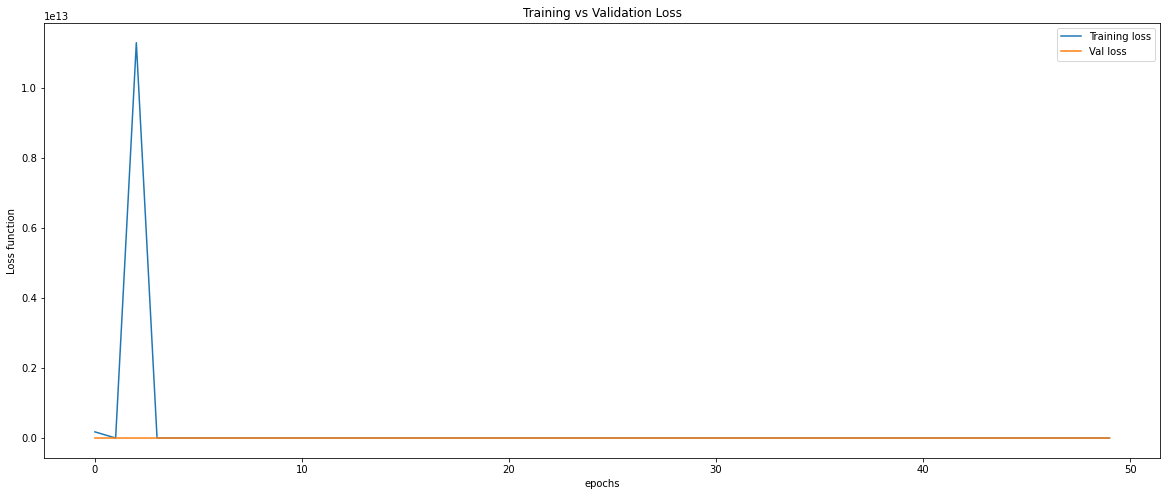

In [29]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"], label = "Val loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [367]:
cony.shape

(431, 5, 1)

In [36]:
pred_train_seq = seq2seq_model.predict(conx)
pred_test_seq = seq2seq_model.predict(conx_test)

#pred_test_seq = seq2seq_model.predict([x_test,noise2])
#pred_test_seq = np.reshape(pred_test_seq,(pred_test_seq.shape[0],3))
#rmse_seq = sqrt(mean_squared_error(y_test, pred_test_seq))
#print(rmse_seq)
y_train_pred = np.reshape(pred_train_seq,(371*5,1))
y_test_pred = np.reshape(pred_test_seq,(86*5,1))
y_train_plot = np.reshape(cony,(371*5,1))
y_test_plot = np.reshape(cony_test,(86*5,1))
pred_noscale = scaler3.inverse_transform(y_train_pred)
test_pred_noscale = scaler3.inverse_transform(y_test_pred)
noscale = y_normaliser.inverse_transform(y_train_plot)
test_noscale = y_normaliser.inverse_transform(y_test_plot)

3/3 [==============================] - 0s 15ms/step


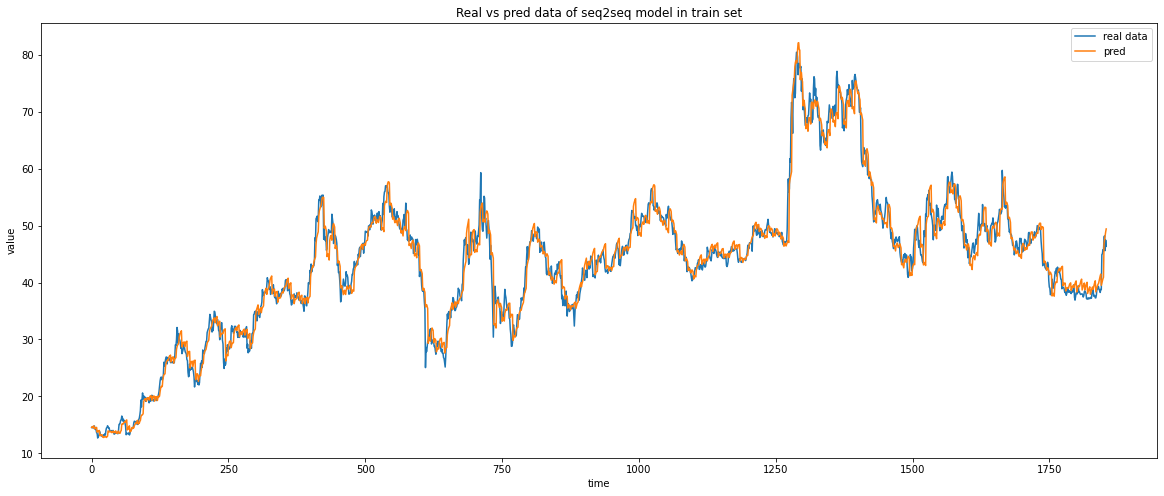

In [37]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(noscale, label = "real data")
plt.plot(pred_noscale, label = "pred")

plt.xlabel("time")
plt.ylabel("value")
plt.title("Real vs pred data of seq2seq model in train set")
plt.legend()
plt.show()

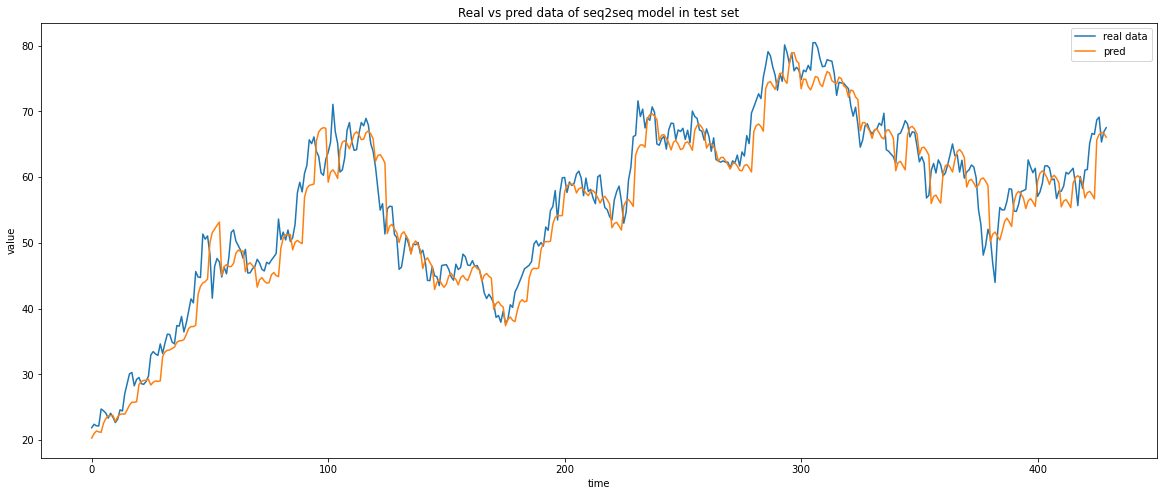

In [38]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(test_noscale, label = "real data")
plt.plot(test_pred_noscale, label = "pred")

plt.xlabel("time")
plt.ylabel("value")
plt.title("Real vs pred data of seq2seq model in test set")
plt.legend()
plt.show()

In [400]:
evaluate_forecasts(noscale,pred_noscale)

(9.436581137055333, 0.964770294964163)

In [401]:
evaluate_forecasts(test_noscale,test_pred_noscale)

(15.592110554704469, 0.9064052686666149)

In [433]:
ahead1.shape

(1960,)

## Strategy

In [674]:
temp0 = np.zeros(21)
atten_train = np.reshape(y_pred_atten_train1,(1938,))
ahead1 = np.hstack((temp0,atten_train))  # index=100 value是100的预测值


temp1 = np.zeros(100)
temp2 = np.zeros(4)
ahead2 = np.hstack((temp1,pred_noscale.reshape(pred_noscale.shape[0]),temp2)) # index=100 value是100的预测值

arr1 = np.reshape(df_train['share_pricing'],(1959,)) # index=100 value是100的实际股价
arr2 = df_train.iloc[:,1].values

pct = (ahead1[1:]/arr1[0:-1])-1
pct[0:20] = 0
temp4 = np.zeros(1)
precent = np.hstack((pct,temp4)) # index=100 value是 100-101 pct change

In [672]:
atten_test = np.reshape(y_pred_atten_test1,(512,))
ahead11 = np.hstack((temp0,atten_test))  # index=100 value是100的预测值
temp3 = np.zeros(3)
ahead33 = np.hstack((temp1,test_pred_noscale.reshape(430,),temp3)) # index=100 value是100的预测值

arr11 = np.reshape(df_test['share_pricing'],(533,)) # index=100 value是100的实际股价
arr22 = df_test.iloc[:,1].values

pct2 = (ahead11[1:]/arr11[0:-1])-1
pct2[0:20] = 0
precent1 = np.hstack((pct2,temp4)) # index=100 value是 100-101 pct change

In [675]:
all_data = np.column_stack((arr1,precent,ahead2,arr2))
all_data.shape

(1959, 4)

In [704]:
arr1[-4]/arr1[100]-1

2.1730769230769234

In [560]:
all_data1 = np.column_stack((arr11,precent1,ahead33,arr22))
all_data1.shape

(533, 4)

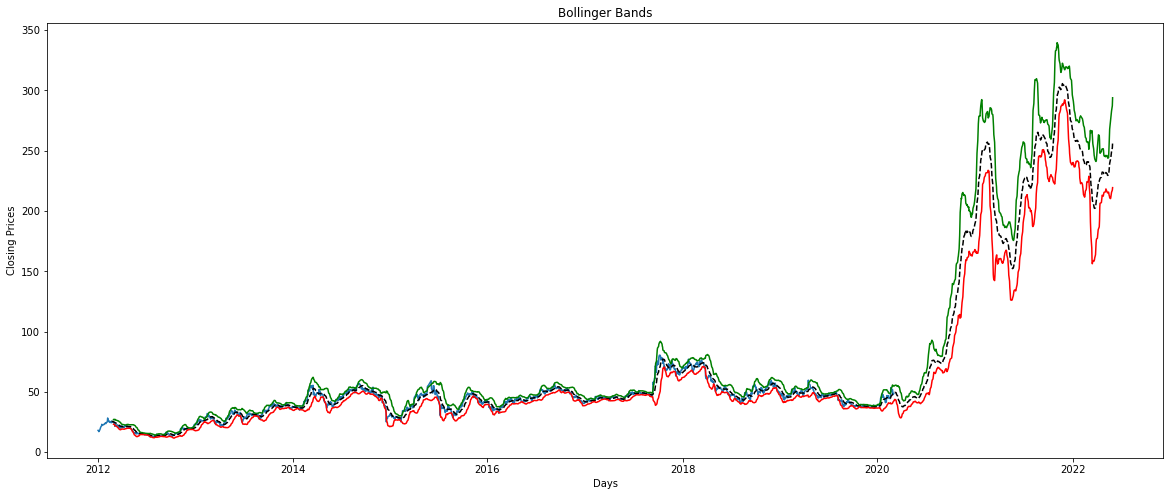

In [705]:

def get_bollinger_bands(prices, rate=15):
    sma = prices.rolling(window =15).mean()
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma,bollinger_up, bollinger_down

sma,bollinger_up, bollinger_down = get_bollinger_bands(alldata_df['share_pricing'], rate=20)
fig, ax = plt.subplots(1,1,figsize=(20, 8))
plt.title('Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(train['share_pricing'][:2000], label='Closing Prices')
plt.plot(sma, label='SMA', color='black', linestyle='dashed')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')


fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=alldata_df.index,y=alldata_df['share_pricing']),secondary_y=False)
fig2.add_trace(go.Scatter(x=alldata_df.index,y=pos/1000),secondary_y=False)
#fig2.add_trace(go.Bar(x=train.index,y=train.iloc[:,1][500:],name='Volume'),secondary_y=True)
fig2.show()

In [740]:
def bband(all_data,sma,bollinger_up, bollinger_down):
    signal = np.zeros(len(all_data))
    for i in range(100,len(all_data)):
        dis1 = sma[i] - all_data[i-1,0]
        dis2 = all_data[i-1,0]- bollinger_down[i-1]
        dis3 = all_data[i-1,0]-sma[i]
        dis4 = bollinger_up[i-1]-all_data[i-1,0]
        if all_data[i-1,0] < sma[i] and  dis1 > 6 * dis2 :
            signal[i] = 1
        elif all_data[i-1,0] > sma[i] and  dis3 > 6 *dis4:
            signal[i] = -1
        else: 
            signal[i] = 0
    short_signal = np.zeros(len(all_data))
    for i in range(100,len(all_data)):
        if all_data[i,1] >= 0.005:
            short_signal[i] = 1
        elif all_data[i,1] < -0.05:
            short_signal[i] = -1
        else: 
            short_signal[i] = 0
            
    long_signal = np.zeros(len(all_data))
    for i in range(99,len(all_data)-5):
        long_pct = all_data[i+5,2]/all_data[i,0]-1
        if long_pct >= 0.03:
            long_signal[i] = 1
        elif long_pct < -0.1:
            long_signal[i] = -1
        else: 
            long_signal[i] = 0  
            
    pos = np.zeros(len(all_data))
    money = np.zeros(1959)
    money[0:100] = 1000000
    wealth = np.zeros(1959)
    wealth[0:100] = 1000000
    for i in range(100,1959):
        #if signal[i]==1 and money[i-1] >= (700 * all_data[i,0]):
        #    pos[i] = pos[i-1]+700
        #    money[i] = money[i-1] - 700 * all_data[i,0]
       # elif signal[i]==-1 and pos[i-1] >= 700:      
        #    pos[i] = pos[i-1]-700
        #    money[i] = money[i-1]+700 * all_data[i,0]
        if long_signal[i] == 1 and money[i-1] >= (800 * all_data[i,0]):
            pos[i] = pos[i-1]+(signal[i]*300+800)
            money[i] = money[i-1]-(signal[i]*300+500) * all_data[i,0]                
        elif long_signal[i] == -1 and pos[i-1] >= 800:
            pos[i] = pos[i-1]-800
            money[i] = money[i-1]+800 * all_data[i,0]   
        elif short_signal[i] == 1 and money[i-1] >= (500 * all_data[i,0]) and long_signal[i]!=-1:
            pos[i] = pos[i-1]+500
            money[i] = money[i-1]-500 * all_data[i,0]  
        elif short_signal[i] == -1 and pos[i-1] >= 500:
            pos[i] = pos[i-1]-500
            money[i] = money[i-1]+500 * all_data[i,0]  

        else:
            pos[i] = pos[i-1]
            money[i] = money[i-1]
        wealth[i] = pos[i]*all_data[i,0] + money[i]
    
    return wealth,pos,money,signal

wealth,pos,money,signal =bband(all_data,sma,bollinger_up, bollinger_down)


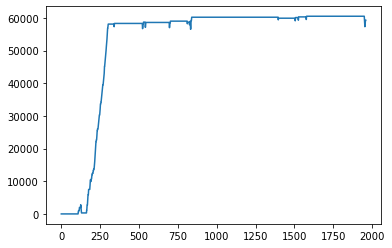

In [741]:
wealth[-1]
#arr1[-1]/arr1[100]
plt.plot(pos)
#plt.plot(wealth)

Maximum drawdown of timing strategy is 2.0950338823722405


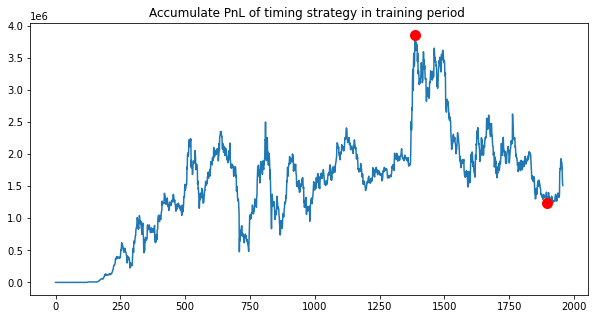

In [743]:
def MDD(wealth):
    pnl = wealth[1:]-wealth[0:-1]
    pnl_sum = pnl.cumsum()
    i = np.argmax(np.maximum.accumulate(pnl_sum) - pnl_sum) # end of the period
    j = np.argmax(pnl_sum[:i]) # start of period
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    plt.title('Accumulate PnL of timing strategy in training period ')
    plt.plot(pnl_sum)
    plt.plot([i, j], [pnl_sum[i], pnl_sum[j]], 'o', color='Red', markersize=10)
    MDD_pct = (pnl_sum[j]-pnl_sum[i])/pnl_sum[i]
    print('Maximum drawdown of timing strategy is %s'%MDD_pct)
MDD(wealth)

In [745]:
def buysell(all_data,sma,bollinger_up, bollinger_down):
    short_signal = np.zeros(len(all_data))
    for i in range(100,len(all_data)):
        if all_data[i,1] >= 0.005:
            short_signal[i] = 1
        elif all_data[i,1] < -0.03:
            short_signal[i] = -1
        else: 
            short_signal[i] = 0
            
            
    pos = np.zeros(len(all_data))
    money = np.zeros(1959)
    money[0:100] = 1000000
    wealth = np.zeros(len(all_data))
    wealth[0:100] = 1000000
    for i in range(100,len(all_data)):
        #if signal[i]==1 and money[i-1] >= (700 * all_data[i,0]):
        #    pos[i] = pos[i-1]+700
        #    money[i] = money[i-1] - 700 * all_data[i,0]
       # elif signal[i]==-1 and pos[i-1] >= 700:      
        #    pos[i] = pos[i-1]-700
        #    money[i] = money[i-1]+700 * all_data[i,0]
        if short_signal[i] == 1 and money[i-1] >= (500 * all_data[i,0]) :
            pos[i] = pos[i-1]+500
            money[i] = money[i-1]-500 * all_data[i,0]  
        elif short_signal[i] == -1 and pos[i-1] >= 500:
            pos[i] = pos[i-1]-500
            money[i] = money[i-1]+500 * all_data[i,0]  


        else:
            pos[i] = pos[i-1]
            money[i] = money[i-1]
        wealth[i] = pos[i]*all_data[i,0] + money[i]
    
    return wealth,pos,money,signal

wealth,pos,money,signal =buysell(all_data,sma,bollinger_up, bollinger_down)
#wealth,pos,money,signal =buysell(all_data1,sma,bollinger_up, bollinger_down)


In [746]:
wealth[-1]
#arr1[-1]/arr1[100]
#plt.plot(pos)
#plt.plot(wealth)

1636025.0

Maximum drawdown of Buy-Sell strategy is 3.653278078843906


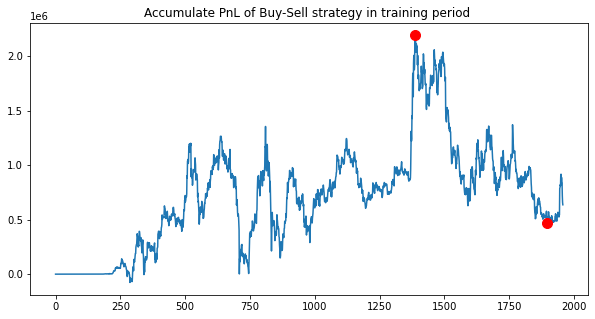

In [747]:
def MDD(wealth):
    pnl = wealth[1:]-wealth[0:-1]
    pnl_sum = pnl.cumsum()
    i = np.argmax(np.maximum.accumulate(pnl_sum) - pnl_sum) # end of the period
    j = np.argmax(pnl_sum[:i]) # start of period
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    plt.title('Accumulate PnL of Buy-Sell strategy in training period ')
    plt.plot(pnl_sum)
    plt.plot([i, j], [pnl_sum[i], pnl_sum[j]], 'o', color='Red', markersize=10)
    MDD_pct = (pnl_sum[j]-pnl_sum[i])/pnl_sum[i]
    print('Maximum drawdown of Buy-Sell strategy is %s'%MDD_pct)
MDD(wealth)

In [648]:
all_data1[200]

array([2.48400000e+02, 3.55605956e-03, 1.91629532e+02, 2.06249960e+01])